In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import uncertainties as u
import uncertainties.unumpy as unp 
import math as m
import scipy as sc
from scipy.special import sinc
import matplotlib as mpl

plt.style.use("Source.mplstyle")

plt.rc("text", usetex=True)  # enable use of LaTeX in matplotlib
plt.rc("font", family="sans-serif", serif="Times New Roman", size=14)  # font settings
plt.rc("text.latex", preamble="\\usepackage{mtpro2} \\usepackage{siunitx} \\usepackage{amsmath}")
plt.rcParams["pgf.texsystem"] = "xelatex"


# 1 bragg angle

In [2]:
d1=u.ufloat(9.1, 0.2)
d2=u.ufloat(15.1, 0.2)
d3=u.ufloat(37,1)
d=d1+d2+d3
print(d)
difference_a=u.ufloat(0.8,0.1)

bragg_angle=unp.arctan(difference_a/(2*d))
print(bragg_angle*1000 ,"mrad ist der bragg winkel")

61.2+/-1.0
6.5+/-0.8 mrad ist der bragg winkel


# 2 intensity dependence and saturation power

In [3]:
P0_before=u.ufloat(0.877,0.005)
P0_after=u.ufloat(0.791,0.005)

IL=1-P0_after/P0_before
print("insertion loss", IL)

insertion loss 0.098+/-0.008


In [11]:
# umrechnungstabelle=pd.read_csv("umrechnung.csv")
umrechnungstabelle=pd.read_csv("data0.csv")
umrechnungstabelle.columns=["dB", "mvpp", "mW"]
def expfunktion(x,a):
    return a*x**2

# mpl.use("pgf")
mpl.use("tkAgg")

x = np.linspace(0, 900, 1000)

popt_umrechnung, pcov=sc.optimize.curve_fit(expfunktion, umrechnungstabelle["mvpp"], umrechnungstabelle['mW'],  absolute_sigma='false', p0=[2.5e-6])

fig, ax = plt.subplots()
ax.scatter(umrechnungstabelle["mvpp"], umrechnungstabelle['mW'], s=20, label='Datapoints from instruction table')
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.plot(x, expfunktion(x, *popt_umrechnung), c="C1", label="Fit", zorder=0)

rect = mpl.patches.FancyBboxPatch((0.1, 0.4), 0.44, 0.1, linewidth=1.5, edgecolor="C1", facecolor="none", transform=ax.transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))
ax.add_patch(rect)

ax.text(0.1, 0.5, '$f(x)=ax^2$\n$a = 2.501(3) \cdot 10^{-6}\ \mathrm{mW/mVpp}^2$', fontsize=12, verticalalignment='top', transform=ax.transAxes)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.xlabel("$U_\mathrm{pp}\,\, (\mathrm{mVpp})$")
plt.ylabel("$P_\mathrm{RF}\ (\mathrm{mW})$")

plt.legend()
plt.tight_layout()
plt.savefig("bilder/umrechnung.pdf", bbox_inches="tight")
print(popt_umrechnung)
print((np.sqrt(np.diag(pcov))))

plt.show()
def transform_pp_tomW(mvpp):
    return expfunktion(mvpp, *popt_umrechnung)*2000
print(popt_umrechnung)

[2.50145725e-06]
[7.61425751e-07]
[2.50145725e-06]


/tmp/ipykernel_9658/201990959.py:36: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


In [5]:
def epsilon2(P_RF,a,P_SAT,b):
    return a* np.sin(np.pi/2*np.sqrt((P_RF - b)/P_SAT))**2

daten_a=pd.read_csv("data1.csv")

print(transform_pp_tomW(0.00318)/np.pi/2)

daten_a_mW=transform_pp_tomW(daten_a["mVPP"])

x = np.linspace(0, 2000, 1000)

#plt.plot(daten_a["mVPP"], daten_a["0.Ordnung"])
#plt.plot(daten_a["mVPP"], daten_a["1.Ordnung"])

popt_epsilon, pcov=sc.optimize.curve_fit(epsilon2, daten_a_mW, daten_a["1.Ordnung"],  absolute_sigma='false', maxfev=10000, p0=[0.8,1000,0])
# plt.plot(x, epsilon2(x, *[0.8, 1000, 0]))
plt.plot(x, epsilon2(x, *popt_epsilon))

plt.plot(daten_a_mW,daten_a["0.Ordnung"], linestyle='none', marker=".", color="blue", label="0th order")
plt.plot(daten_a_mW, daten_a["1.Ordnung"], linestyle='', marker='.', color="orange", label='1st order')
plt.ylabel('$P$ (mW)')
plt.xlabel("$P_{\mathrm{RF}}$ (mW)")
plt.legend()
plt.show()


8.051882934866623e-09


/usr/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

# 3

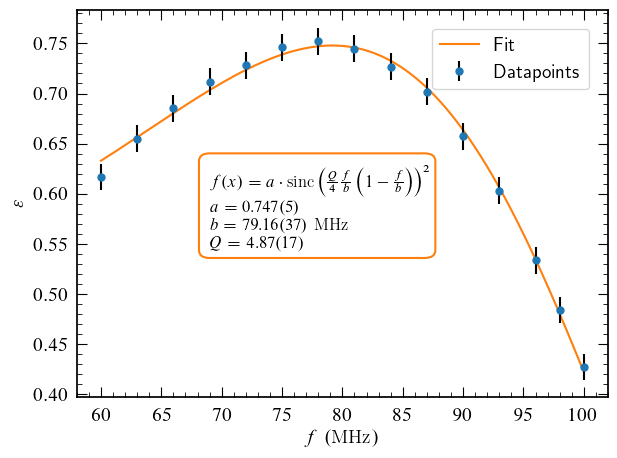

Q Faktor ist  4.87+/-0.17


In [4]:
daten3=pd.read_csv("data2.csv")
daten3.columns = ["frequenz", "1.Ordnung", "Abstand(mm)"]
power=unp.uarray(daten3["1.Ordnung"], [0.01]*len(daten3["1.Ordnung"]))
angle_distance_measure=unp.uarray(daten3["Abstand(mm)"]/10, [0.1]*len(daten3["Abstand(mm)"]))
f0=80
d4=u.ufloat(140,3)
dges=d1+d2+d4
#print(dges)
def sinc2(F,a,Q,b):
    return a*sinc(Q/4*F/b*(1-F/b))**2
epsilon3=power/P0_after

F=daten3["frequenz"]

angles_bragg=unp.arctan(angle_distance_measure/(2*dges))
#print(angles_bragg)
epsilon=daten3["1.Ordnung"]/P0_after
x=np.linspace(60,100,1000)
popt3, pcov3=sc.optimize.curve_fit(sinc2, F, unp.nominal_values(epsilon3), sigma=unp.std_devs(epsilon3), absolute_sigma='true' ,p0=[0.8,5,80])
#print(popt3)
#print(np.sqrt(np.diag(pcov3)))
fig, ax = plt.subplots()
ax.errorbar(daten3["frequenz"], unp.nominal_values(epsilon3),yerr=unp.std_devs(epsilon3), label='Datapoints', fmt=".", ecolor="k", ms=10)
ax.plot(x, sinc2(x, *popt3), label='Fit', zorder=0)

ax.set_ylabel("$\\varepsilon$")
ax.set_xlabel("$f\ (\mathrm{MHz})$")

ax.text(0.25, 0.6, "$f(x) = a \cdot \mathrm{sinc}\left( \\frac{Q}{4}\\frac{f}{b} \left(1-\\frac{f}{b} \\right)\\right)^2 $\n $a = 0.747(5) $\n$ b = 79.16(37)\ \mathrm{MHz} $\n$Q = 4.87(17)$", fontsize=12, verticalalignment='top', transform=ax.transAxes)
rect = mpl.patches.FancyBboxPatch((0.25, 0.38), 0.405, 0.23, linewidth=1.5, edgecolor="C1", facecolor="none", transform=ax.transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))
ax.add_patch(rect)

plt.legend()
plt.tight_layout()
plt.show()
#plt.plot(daten3["frequenz"], unp.nominal_values}(angles_bragg))
#daten3
Q1=u.ufloat(popt3[1], (np.sqrt(np.diag(pcov3)))[1])
print("Q Faktor ist ", Q1)

[7.7697868e-05]
[1.03417167e-06]


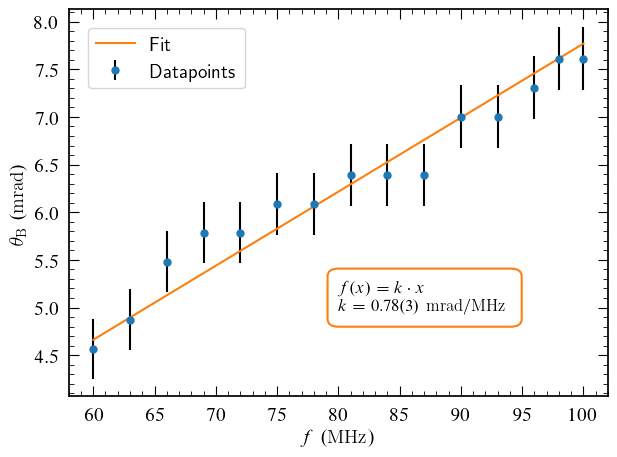

In [19]:
def linearfunction(x,a):
    return a*x
popt_gerade, pcov_gerade=sc.optimize.curve_fit(linearfunction, F, unp.nominal_values(angles_bragg), sigma=unp.std_devs(angles_bragg), absolute_sigma='true' )
print(popt_gerade)

fig, ax = plt.subplots()
ax.errorbar(daten3["frequenz"], unp.nominal_values(angles_bragg)*1000,yerr=unp.std_devs(angles_bragg)*1000, label='Datapoints', fmt='.', ecolor="k", ms=10)
ax.plot(x, linearfunction(x, *popt_gerade)*1000, label='Fit')

ax.text(0.5, 0.3, "$f(x)=k\cdot x $\n$ k = 0.78(3)\ \mathrm{mrad/MHz} $", fontsize=12, verticalalignment='top', transform=ax.transAxes)
rect = mpl.patches.FancyBboxPatch((0.5, 0.2), 0.32, 0.11, linewidth=1.5, edgecolor="C1", facecolor="none", transform=ax.transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))
ax.add_patch(rect)

print(np.sqrt(np.diag(pcov_gerade)))

ax.set_xlabel("$f\ (\mathrm{MHz})$")
ax.set_ylabel("$\\theta_{\mathrm{B}}\ (\mathrm{mrad})$")
plt.legend()
plt.tight_layout()
plt.show()

# 4

[0.79740462 4.45428036 0.78557896]
[0.06065549 0.35828488 0.03142346]
Q Faktor ist 4.5+/-0.4


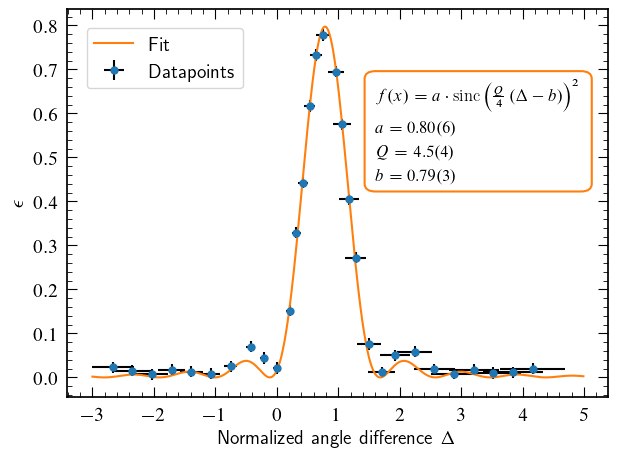

In [48]:
daten4=pd.read_csv("data3.csv")
daten4
first_order=unp.uarray(daten4["1.Ordnung"], [0.01]*len(daten4["1.Ordnung"]))
ticks=unp.uarray(daten4["ticks"], [0.5]*len(daten4["ticks"]))

epsilon4=first_order/P0_after
radians=ticks/25/180*np.pi

winkel=radians/bragg_angle

def deltasinc(delta, a,Q, b):
    return a*sinc(Q/4*(delta-b))**2
popt_baldamende, pcov_baldamende=sc.optimize.curve_fit(deltasinc, unp.nominal_values(winkel), unp.nominal_values(epsilon4), sigma=unp.std_devs(winkel), absolute_sigma='true', p0=[0.8,1,1] )
Q2=u.ufloat(popt_baldamende[1], (np.sqrt(np.diag(pcov_baldamende)))[1])
winkelrange=np.arange(-3,5,0.01)

fig, ax = plt.subplots()
ax.errorbar(unp.nominal_values(winkel), unp.nominal_values(epsilon4), xerr=unp.std_devs(winkel), yerr=unp.std_devs(epsilon4), label='Datapoints', fmt=".", ecolor="k", ms=10)
ax.plot(winkelrange, deltasinc(winkelrange, *popt_baldamende), label='Fit')

ax.set_xlabel("Normalized angle difference $\Delta$")
ax.set_ylabel("$\epsilon$")
print(popt_baldamende)
print(np.sqrt(np.diag(pcov_baldamende)))

ax.text(0.57, 0.82, "$\\\\f(x)=a\cdot \mathrm{sinc}\left( \\frac{Q}{4}\left( \Delta-b \\right)\\right)^2$\\\\[1ex]$a = 0.80(6) $\\\\[1ex]$Q =4.5(4) $\\\\[1ex]$b = 0.79(3) $", fontsize=12, verticalalignment='top', transform=ax.transAxes)
rect = mpl.patches.FancyBboxPatch((0.57, 0.55), 0.38, 0.27, linewidth=1.5, edgecolor="C1", facecolor="none", transform=ax.transAxes, boxstyle=mpl.patches.BoxStyle("Round", pad=0.02))
ax.add_patch(rect)
print("Q Faktor ist", Q2)

plt.legend()
plt.tight_layout()
plt.show()


# 5

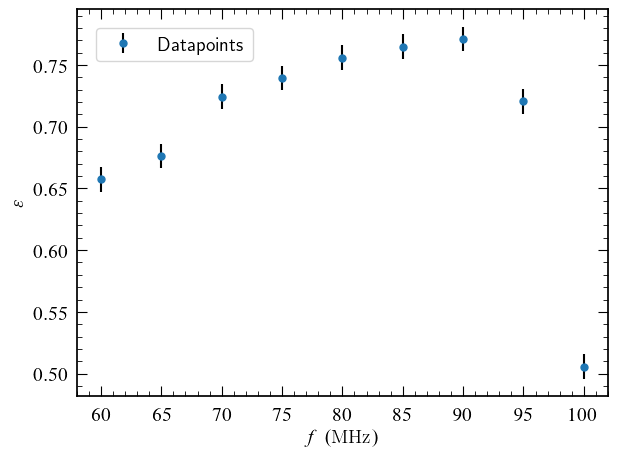

In [34]:
daten5=pd.read_csv("data4.csv")

frequency=unp.uarray(daten5["Frequenz"], [0]*len(daten5["Frequenz"]))
power5=unp.uarray(daten5["Power"], [0.01]*len(daten5["Power"]))
daten5
efficiency=power5/P0_after

fig, ax = plt.subplots()
ax.errorbar(unp.nominal_values(frequency),unp.nominal_values(efficiency), yerr=unp.std_devs(power5), fmt=".", label="Datapoints", ecolor="k", ms=10)

ax.set_ylabel("$\\varepsilon$")
ax.set_xlabel("$f\ (\mathrm{MHz})$")

plt.legend()
plt.tight_layout()
# plt.savefig("bilder/plot5.pdf", bbox_inches="tight")
